In [1]:
import adios2
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from adios2toolspy import SuperCell, BpParticles, BpFields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
root = '/gpfs/alpine/proj-shared/fus137/johnd/flatfoil-summit_10-29/run2Dratio01TripleNI1000/'

Loading hx_fc from File: tfd.029000.xdmf
(2999, 1920, 1)


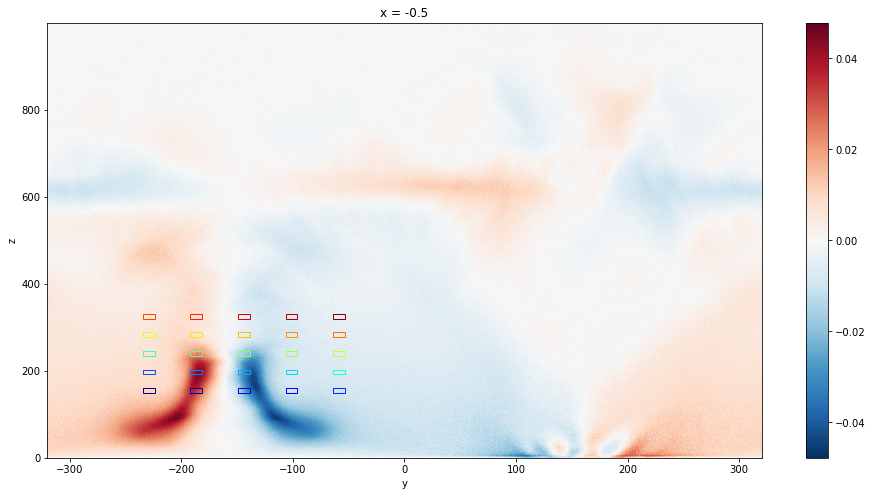

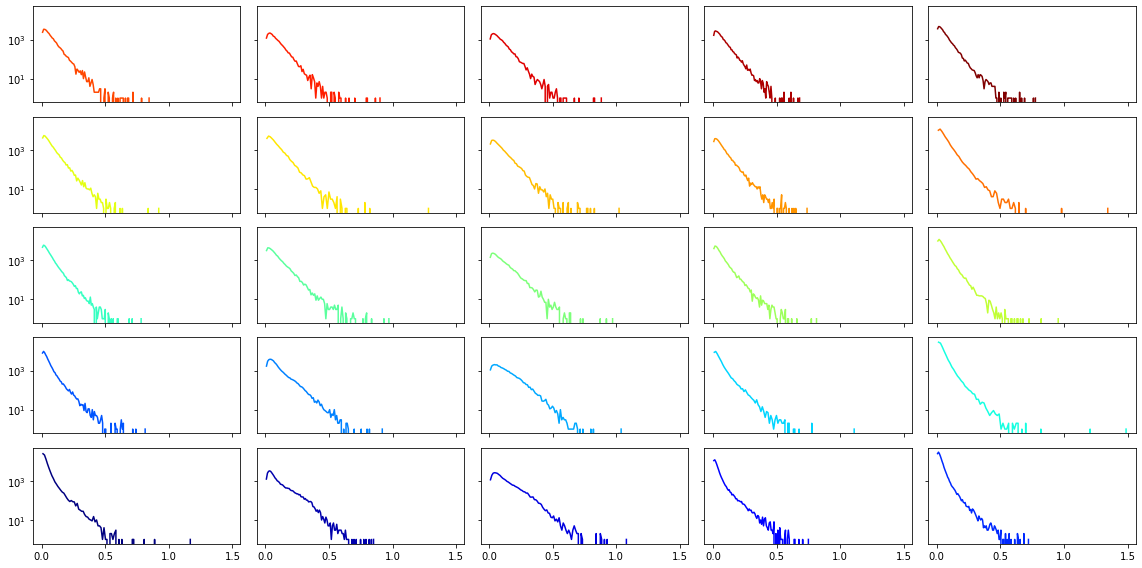

In [3]:
origin = (-232,150)
#origin = (-160,160)
histGrid(root, 'hx_fc', -1 , (5, 5), origin, cellsPerPatch=32, zrange=(0,1000), spacing=3)

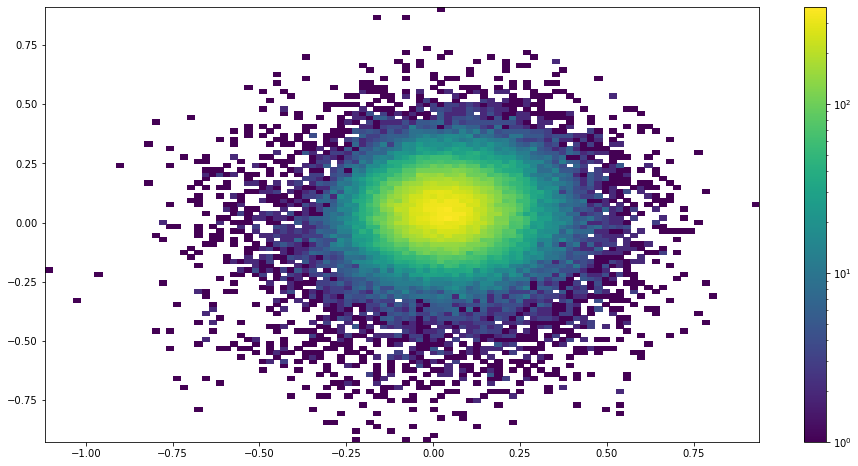

In [4]:
time = '29000'
path = root + 'checkpoint_' + time + '.bp'
patch = np.array((2,0))*32 + origin
numPatches = 1
cellsPerPatch=32
nrows, ncols = 1, 1
spacing = 1
h5p = H5Processor(root)
corners, numPatches = h5p.getPatches(origin, nrows=nrows, ncols=ncols, cellsPerPatch=cellsPerPatch, spacing=spacing)

SC = SuperCell(path, corners[0], patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
SC.histogram2D(100)

This was working on grid of 2d hist, didn't use
fig, axes = plt.subplots(4,3, squeeze=False)
for i in range(4):
    for j in range(3):
        time = (i*3+j)*1000 + 17000
        path = root + 'checkpoint_' + str(time) + '.bp'
        SC = SuperCell(path, corners[0], patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
        SC.histogram2D(100, axes[i,j], fig)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


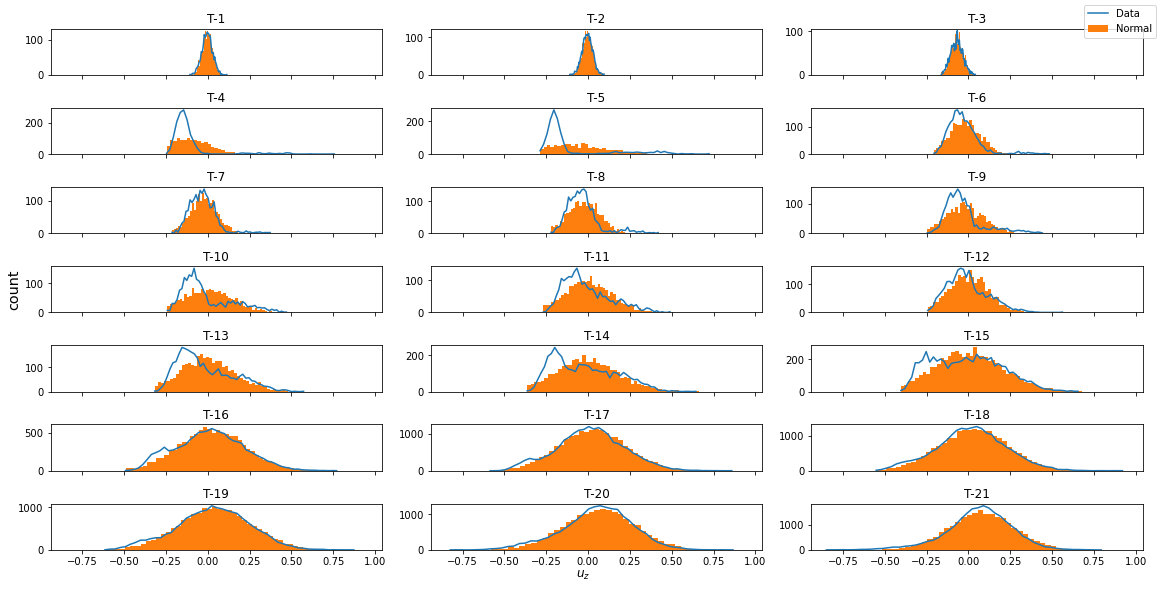

In [96]:
fig, axes = plt.subplots(7,3, squeeze=False, sharex=True)
data_t = []
probNormals = []
probNormals2 = []
probDatas = []
binsData = []
binsNormal = []
for i in range(7):
    for j in range(3):
        time = (i*3+j)*1000+1000
        path = root + 'checkpoint_' + str(time) + '.bp'
        SC = SuperCell(path, corners[0], patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
        h = SC.histogramV(50, dim='z')
        axes[i,j].plot(h[1][:-1], h[0], label='Data')

        std = SC.residents['uz'].std()
        mean = SC.residents['uz'].mean()
        gaussianSamples = np.random.normal(loc=mean, scale=std, size=SC.residents['uz'].shape[0])
        gaussianSamples2 = np.random.normal(loc=mean, scale=std, size=SC.residents['uz'].shape[0])

        n, bins, _ = axes[i,j].hist(gaussianSamples, bins=h[1], label='Normal')
        n2, bins2 = np.histogram(gaussianSamples2, bins=h[1])
        probNormals.append( n/(n.sum()*np.diff(bins)) )
        probNormals2.append( n2/(n2.sum()*np.diff(bins2)) )
        probDatas.append( h[0]/(h[0].sum()*np.diff(h[1])) )
        binsData.append(h[1])
        binsNormal.append(bins)
        axes[i,j].set_title(f'T-{int(time/1000)}')
        data_t.append(SC.residents)
fig.tight_layout()
fig.legend(['Data', 'Normal'])
fig.text(0.5, 0.0, r'$u_z$', ha='center', fontsize='large')
fig.text(0.0, 0.5, 'count', va='center', rotation='vertical', fontsize='x-large')
fig.savefig('Uz-Evolution.eps')

/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/ccs/home/johnd/.conda/envs/xarr_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the 

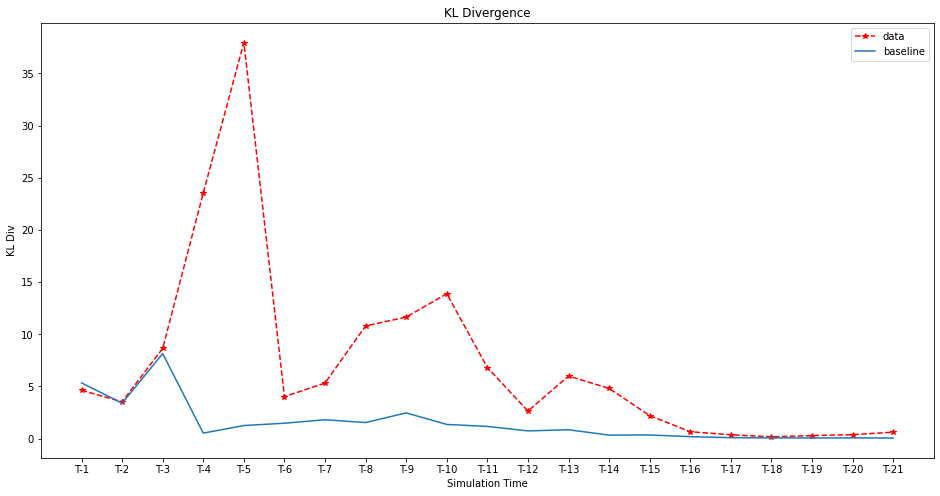

In [98]:
klDivs = []
baselines = []
xtics = [f'T-{x}' for x in range(1,22)]
for bdata, bnormal, probData, probNormal, probNormal2 in zip(binsData, binsNormal, probDatas, probNormals, probNormals2):
    div = probData * (np.log(probData) - np.log(probNormal))
    div = div[np.logical_not(np.isnan(div))]
    div = div[np.logical_not(np.isinf(div))]
    klDivs.append( div.sum() )
    
    base = probNormal * (np.log(probNormal) - np.log(probNormal2))
    base = base[np.logical_not(np.isnan(base))]
    base = base[np.logical_not(np.isinf(base))]
    baselines.append(base.sum() )
    #print((probData*np.diff(bdata)).sum(), (probNormal*np.diff(bnormal)).sum())
plt.plot(xtics, klDivs, 'r--*', label='data')
plt.plot(xtics, baselines, label = 'baseline')
plt.title('KL Divergence')
plt.legend()
plt.xlabel('Simulation Time')
plt.ylabel('KL Div')
plt.savefig('kl-divergence.eps')
# fig, axes = plt.subplots(7,3, squeeze=False, sharex=True)
# for i in range(7):
#     for j in range(3):
#         axes[i,j].plot(binsNormal[i*3+j][:-1], probNormals[i*3 + j])
#         axes[i,j].plot(binsData[i*3+j][:-1], probDatas[i*3 + j])
        #axes[i,j].plot(probDatas[i*3+j] * (np.log(probDatas[i*3+j]) - np.log(probNormals[i*3+j])))


In [7]:
path = root + 'checkpoint_' + '10000' + '.bp'
SC = SuperCell(path, corners[0], patches=numPatches, species='electron', cellsPerPatch=cellsPerPatch)
h = SC.histogramV(100, dim='z')
#SC.residents.to_csv('toy_data.csv')

In [12]:
import pickle
with open('time_series_prts.pkl', 'wb') as f:
    pickle.dump(data_t, f)


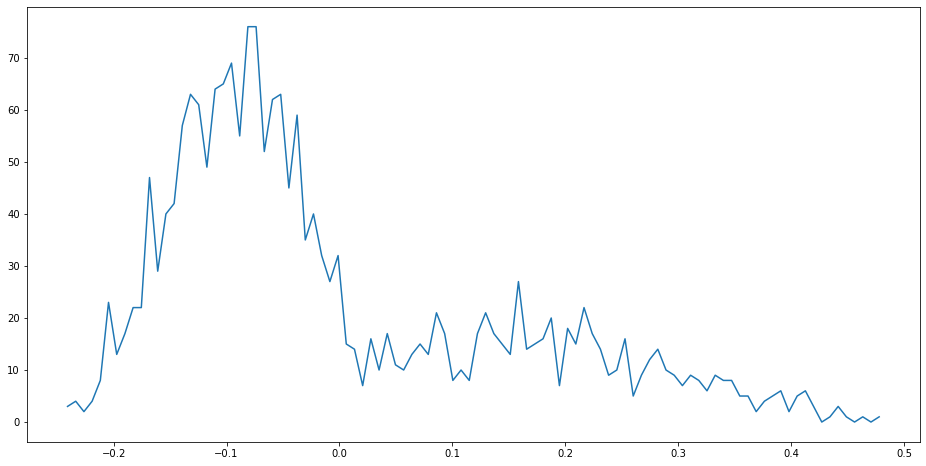

In [8]:
plt.plot(h[1][:-1], h[0])

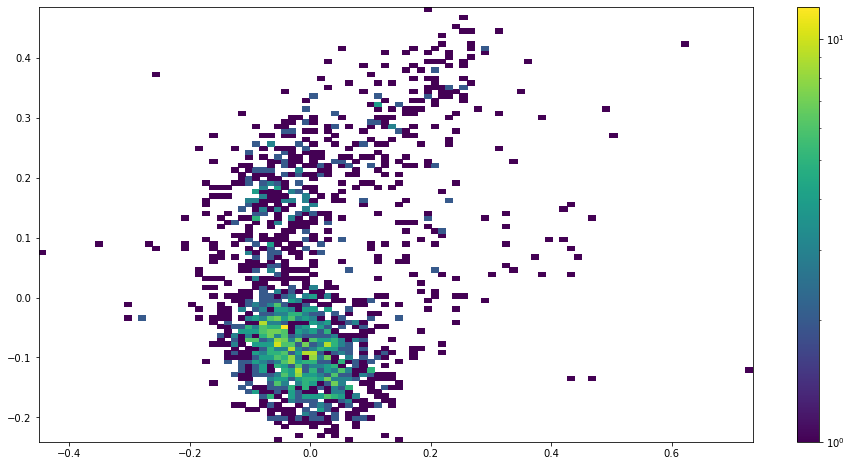

In [18]:
SC.histogram2D(100)

In [17]:
path = root + 'checkpoint_' + '10000' + '.bp'
SC = SuperCell(path, corners[0], patches=20, species='electron', cellsPerPatch=32)
prts = SC._SuperCell__collectPrts(getPositions=True)

SC.residents.memory_usage(index=False).sum()/1e9
SC.residents.to_csv('conditional_prts.csv')

Loading rho_e from File: tfd_moments.010000.xdmf
Loading pz_e from File: tfd_moments.010000.xdmf
Loading tyz_e from File: tfd_moments.010000.xdmf


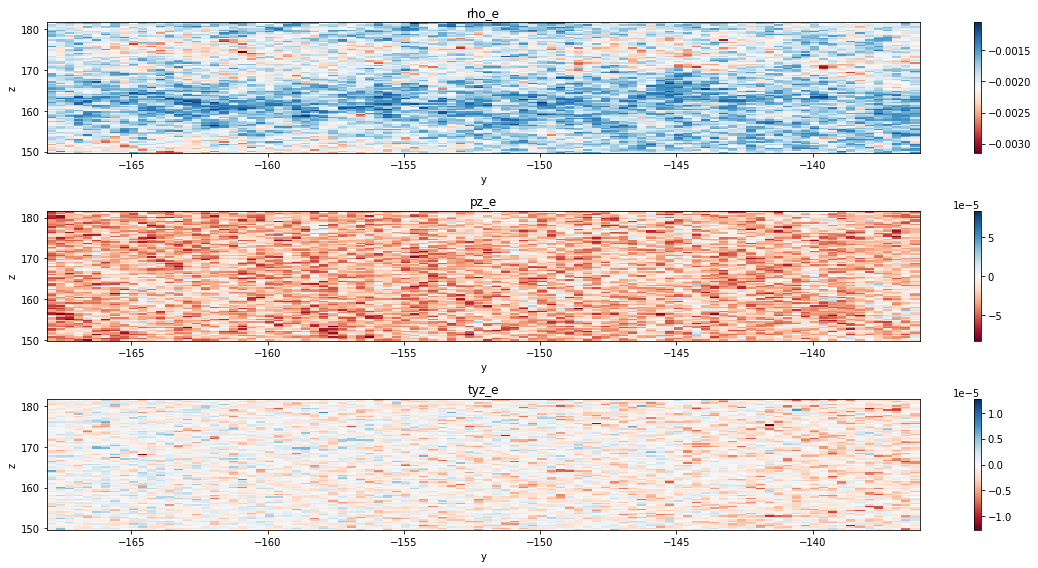

In [31]:
fieldGrid(root, ['rho_e', 'pz_e', 'tyz_e'], [10], zrange=(150,182), yrange=(-168,-136), timeAveraged=True)
#h5p.attributes